# SCNIEC+

This notebook runs the SCENIC+ framework for unpaired scRNA-seq and scATAC-seq on the tumor cells from the Spermatogenesis Mouse dataset 

In [1]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
sys.path.append('/home/sussmanj/miniconda3/envs/scenicplus/lib/')
_stderr = sys.stderr
null = open(os.devnull,'wb')

%matplotlib inline

In [2]:
import importlib
import sys
import os 
import scanpy as sc
from scipy.io import mmread
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from scenicplus.scenicplus_class import SCENICPLUS, create_SCENICPLUS_object
from scenicplus.loom import *
from scenicplus.preprocessing.filtering import *
from pycisTopic.cistopic_class import *
from pycisTopic.lda_models import evaluate_models
from pycisTopic.clust_vis import run_umap
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
import pickle
import dill
from pycisTopic.clust_vis import *
from pycisTopic.topic_binarization import *
from pycisTopic.diff_features import *
from pycisTopic.lda_models import run_cgs_models_mallet
import scipy.sparse as sp
import scipy.io as spio
import pyranges as pr
import numpy as  np
from pycistarget.utils import region_names_to_coordinates
from pycisTopic.lda_models import run_cgs_models
from scenicplus.wrappers.run_pycistarget import run_pycistarget
import pybiomart as pbm
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
from scenicplus.eregulon_enrichment import score_eRegulons
import seaborn as sns
from scenicplus.plotting.dotplot import heatmap_dotplot
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
from scenicplus.RSS import *
from scenicplus.plotting.correlation_plot import *
from pycisTopic.diff_features import find_highly_variable_features
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
import seaborn as sns
import sklearn
from scenicplus.differentiation_potential import *

/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-14 14:37:36,098	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Generate cisTopic object from ATAC counts matrix and save to file 

In [5]:
#Create cisTopic object from the counts matrix 
sparse_csr_matrix=spio.mmread('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_Metacells_ATAC_Peaks_Sparse.mtx').tocsr()
cell_list = []
region_list = [] 

with open("/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_Metacells_ATAC_Cell_Names.txt", "r") as file:
    cell_list = [line.strip() for line in file]
with open("/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_Metacells_ATAC_Region_Names.txt", "r") as file:
    region_list = [line.strip() for line in file]
region_list = [s.replace('-', ':', 1) for s in region_list]

path_to_blacklist='/mnt/isilon/tan_lab/sussmanj/Single_Cell_Tools/ScenicPlus/Genome_Files/hg38-blacklist.v2.bed'

In [6]:
cistopic_obj = create_cistopic_object(fragment_matrix=sparse_csr_matrix, cell_names=cell_list, region_names=region_list,
                                      path_to_blacklist=path_to_blacklist)

2024-11-12 23:30:17,703 cisTopic     INFO     Removing blacklisted regions
2024-11-12 23:30:19,235 cisTopic     INFO     Creating CistopicObject
2024-11-12 23:30:22,788 cisTopic     INFO     Done!


In [8]:
#Add cell metadata
cell_data =  pd.read_csv('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_Metacells_ATAC_Metadata.txt', sep='\t')
cell_data.index = cell_list
cistopic_obj.add_cell_data(cell_data)

In [9]:
#Save cisTopic object
pickle.dump(cistopic_obj, open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_Metacells_ATAC_cistopic_obj.pkl', 'wb'))

In [10]:
#Check the cisTopic object
print(cistopic_obj)

CistopicObject from project cisTopic with n_cells × n_regions = 3742 × 180317


Load in the cisTopic object and perform topic modeling

GO AND RUN MODELS

In [4]:
#Load cisTopic object
cistopic_obj = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_Metacells_ATAC_cistopic_obj.pkl', 'rb'))
print(cistopic_obj)

CistopicObject from project cisTopic with n_cells × n_regions = 3742 × 180317


In [3]:
#Load models 
models = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_Metacells_ATAC_Models_500_iter_LDA.pkl', 'rb'))

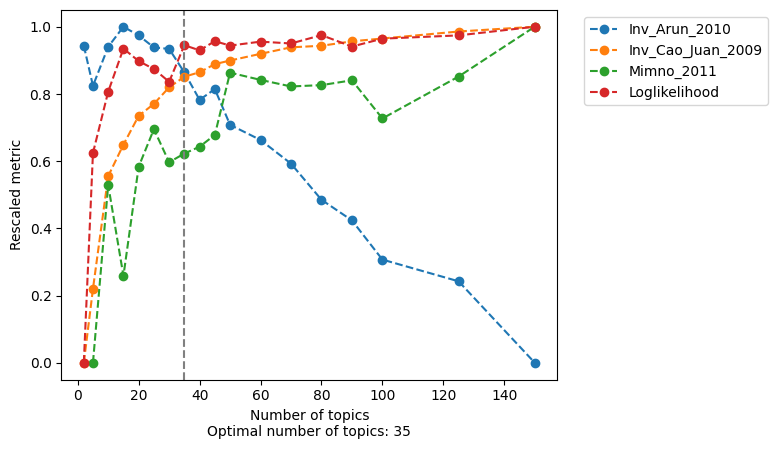

In [5]:
numTopics = 35
model = evaluate_models(models,
                     select_model = numTopics,
                     return_model = True,
                     metrics = ['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics = False)

In [6]:
#Add model to cisTopic object and save again 
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_Metacells_ATAC_cistopic_obj_with_model.pkl', 'wb'))

In [7]:
#Run UMAP
run_umap(cistopic_obj, target = 'cell', scale = True)

2024-11-14 11:47:08,989 cisTopic     INFO     Running UMAP


/home/sussmanj/miniconda3/envs/scenicplus/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


Visualization

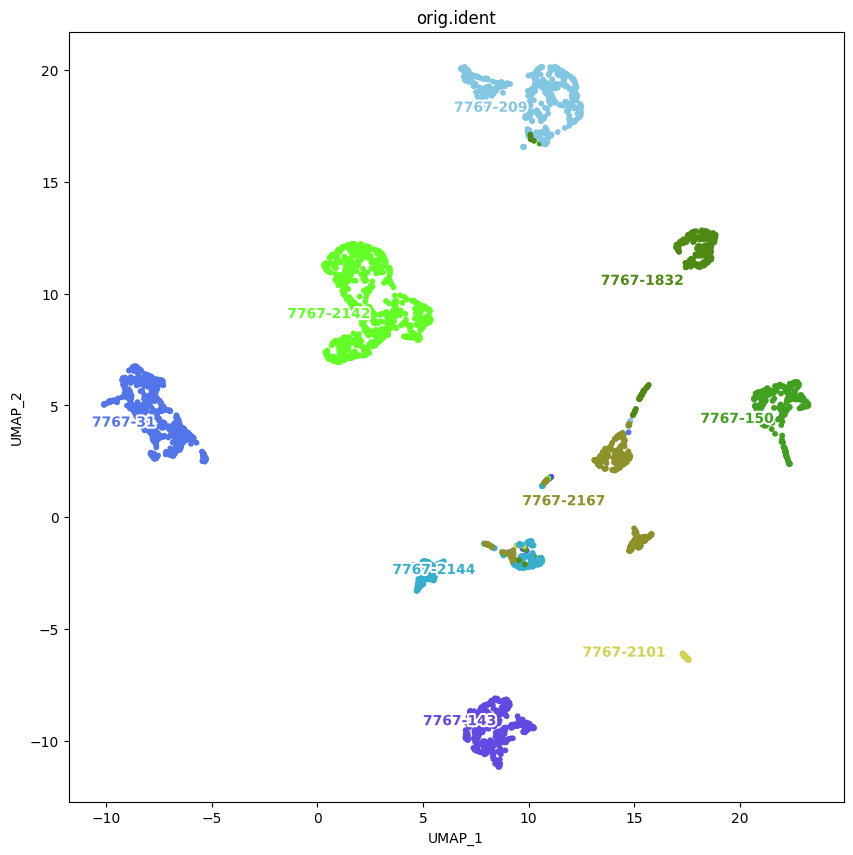

2024-11-14 11:49:36,060 fontTools.subset INFO     maxp pruned
2024-11-14 11:49:36,088 fontTools.subset INFO     cmap pruned
2024-11-14 11:49:36,105 fontTools.subset INFO     kern dropped
2024-11-14 11:49:36,111 fontTools.subset INFO     post pruned
2024-11-14 11:49:36,120 fontTools.subset INFO     FFTM dropped
2024-11-14 11:49:36,131 fontTools.subset INFO     GPOS pruned
2024-11-14 11:49:36,144 fontTools.subset INFO     GSUB pruned
2024-11-14 11:49:36,167 fontTools.subset INFO     glyf pruned
2024-11-14 11:49:36,175 fontTools.subset INFO     Added gid0 to subset
2024-11-14 11:49:36,180 fontTools.subset INFO     Added first four glyphs to subset
2024-11-14 11:49:36,186 fontTools.subset INFO     Closing glyph list over 'GSUB': 23 glyphs before
2024-11-14 11:49:36,191 fontTools.subset INFO     Glyph names: ['.notdef', '.null', 'A', 'M', 'P', 'U', 'd', 'e', 'five', 'g', 'i', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 'space', 't', 'two', 'underscore', 'zero']
2024-11-14 1

In [14]:
plot_metadata(
    cistopic_obj,
    reduction_name = 'UMAP',
    variables = ['orig.ident'],
    figsize = (10, 10), 
    save = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Figures/AML_UMAP_CisTopics.jpg")

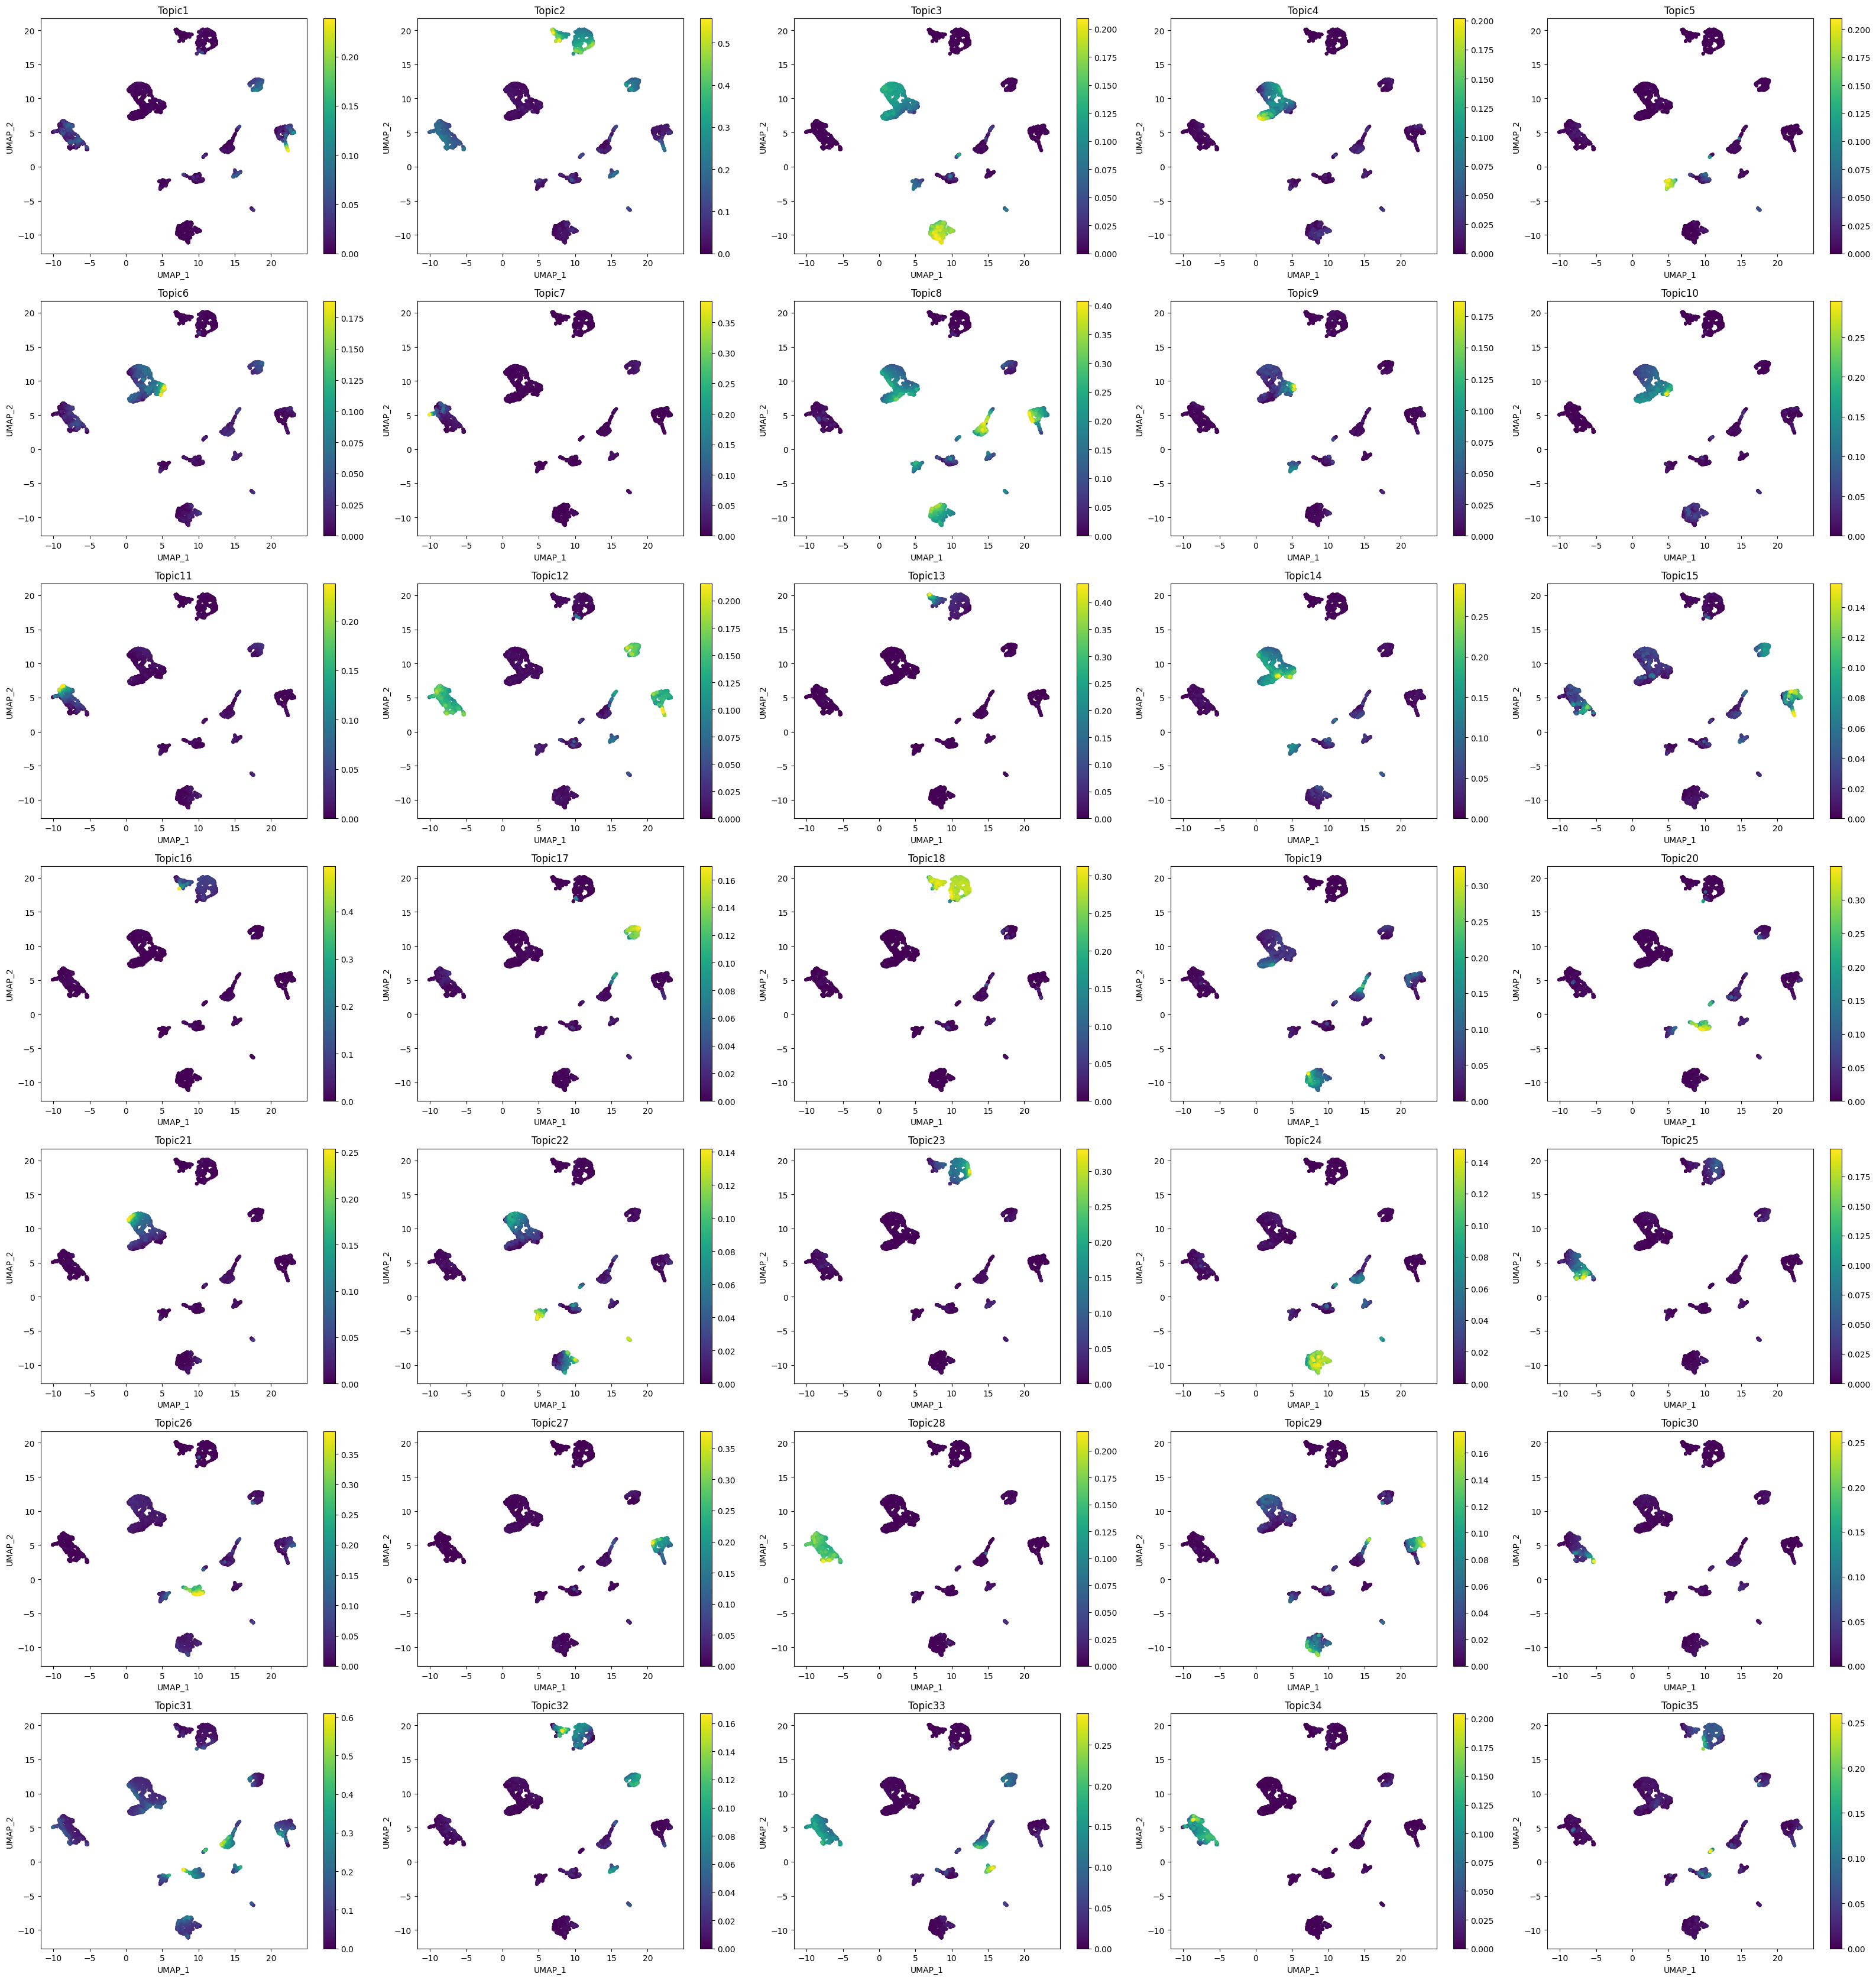

In [15]:
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 5, 
           save = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Figures/AML_CisTopics.png")

Inferring candidate enhancer regions

In [17]:
cell_data =  pd.read_csv('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_Metacells_ATAC_Metadata.txt', sep='\t')
cell_data

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,predicted.t.traj.ptime.score,predicted.t.traj.ptime,predicted.m.traj.ptime.score,predicted.m.traj.ptime,predicted.celltype_refmap.score,predicted.celltype_refmap,predicted.celltypegeneral_refmap.score,predicted.celltypegeneral_refmap,predicted.trajectory.score,predicted.trajectory
0,7767-143,209701,10260,103680,45625,0.180545,16.603375,0.180545,17.989711,0.641201,Mono,0.974288,Mature-Myeloid,0.974288,Myeloid
1,7767-143,229089,10022,108220,45051,0.273937,16.233395,0.161399,17.737274,1.000000,Mono,1.000000,Mature-Myeloid,1.000000,Myeloid
2,7767-143,61343,7362,233915,69199,0.543962,5.283531,0.176585,14.046130,0.810106,Mono,0.926973,Mature-Myeloid,0.926973,Myeloid
3,7767-143,75706,8061,128829,53829,0.176943,5.491798,0.133017,15.037070,0.679153,Mono,0.946465,Mature-Myeloid,0.946465,Myeloid
4,7767-143,158119,9603,134727,53493,0.196657,5.283531,0.149704,15.037070,0.816317,Mono,0.964800,Mature-Myeloid,0.964800,Myeloid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3737,7767-1832,107615,8816,134652,55745,0.497127,4.663026,0.157539,9.337897,1.000000,GMP,1.000000,Progenitor-Myeloid,1.000000,Progenitor
3738,7767-1832,45179,6535,230204,73019,0.466564,4.663026,0.107320,9.337897,0.811624,GMP,0.811624,Progenitor-Myeloid,0.811624,Progenitor
3739,7767-1832,73168,7715,204975,69272,0.456909,4.663026,0.191277,9.337897,0.948560,GMP,0.948560,Progenitor-Myeloid,1.000000,Progenitor
3740,7767-1832,63628,7469,140025,56164,0.508521,4.663026,0.124287,9.337897,1.000000,GMP,1.000000,Progenitor-Myeloid,1.000000,Progenitor


In [3]:
#Load cisTopic object
cistopic_obj = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_Metacells_ATAC_cistopic_obj_with_model.pkl', 'rb'))
print(cistopic_obj)

CistopicObject from project cisTopic with n_cells × n_regions = 3742 × 180317


In [4]:
#Binarize topics, using the 'otsu' method
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
#Calculating DARs per cell type 
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)

2024-11-14 14:38:05,181 cisTopic     INFO     Imputing region accessibility
2024-11-14 14:38:05,182 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-11-14 14:38:06,905 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2024-11-14 14:38:08,610 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2024-11-14 14:38:10,323 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2024-11-14 14:38:12,034 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2024-11-14 14:38:13,747 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2024-11-14 14:38:15,454 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2024-11-14 14:38:17,161 cisTopic     INFO     Impute region accessibility for regions 140000-160000
2024-11-14 14:38:18,835 cisTopic     INFO     Impute region accessibility for regions 160000-180000
2024-11-14 14:38:20,560 cisTopic     

In [6]:
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='predicted.celltype_refmap', split_pattern = '-', adjpval_thr=0.05, log2fc_thr=np.log2(1.5), n_cpu=4)

2024-11-14 14:38:29,206	INFO worker.py:1724 -- Started a local Ray instance.


2024-11-14 14:38:29,737 cisTopic     INFO     Subsetting data for CLP (1 of 3742)
2024-11-14 14:38:34,326 cisTopic     INFO     Computing p-value for CLP
2024-11-14 14:38:57,392 cisTopic     INFO     Computing log2FC for CLP
2024-11-14 14:38:59,431 cisTopic     INFO     CLP done!
2024-11-14 14:38:59,536 cisTopic     INFO     Subsetting data for DC-Progenitor (63 of 3742)
2024-11-14 14:39:00,041 cisTopic     INFO     Computing p-value for DC-Progenitor
2024-11-14 14:39:21,733 cisTopic     INFO     Computing log2FC for DC-Progenitor
2024-11-14 14:39:22,018 cisTopic     INFO     DC-Progenitor done!
2024-11-14 14:39:22,137 cisTopic     INFO     Subsetting data for EffectorT (12 of 3742)
2024-11-14 14:39:22,629 cisTopic     INFO     Computing p-value for EffectorT
2024-11-14 14:39:44,025 cisTopic     INFO     Computing log2FC for EffectorT
2024-11-14 14:39:44,328 cisTopic     INFO     EffectorT done!
2024-11-14 14:39:44,452 cisTopic     INFO     Subsetting data for GMP (858 of 3742)
2024-11

In [8]:
markers_dict

{'CLP': Empty DataFrame
 Columns: [Log2FC, Adjusted_pval, Contrast]
 Index: [],
 'DC-Progenitor':                             Log2FC  Adjusted_pval       Contrast
 chr3:128218162-128218363  4.355368   2.708700e-11  DC-Progenitor
 chr9:29740542-29740779    3.927810   1.245943e-10  DC-Progenitor
 chr5:2836182-2836403      3.882032   1.769535e-10  DC-Progenitor
 chr5:23527585-23527828    3.879231   1.922671e-10  DC-Progenitor
 chr6:156226853-156227270  3.790056   5.488374e-10  DC-Progenitor
 ...                            ...            ...            ...
 chr11:57776081-57776325   0.585159   1.748462e-06  DC-Progenitor
 chr14:24049030-24049276   0.585129   3.110329e-11  DC-Progenitor
 chr5:58751235-58751546    0.585014   2.422362e-06  DC-Progenitor
 chr5:146515985-146516803  0.585004   7.869637e-16  DC-Progenitor
 chr7:102713109-102713645  0.584976   3.766506e-16  DC-Progenitor
 
 [25478 rows x 3 columns],
 'EffectorT':                             Log2FC  Adjusted_pval   Contrast
 chr2:1

In [9]:
filtered_markers_dict = {k: v for k, v in markers_dict.items() if not v.empty}
print(filtered_markers_dict)

{'DC-Progenitor':                             Log2FC  Adjusted_pval       Contrast
chr3:128218162-128218363  4.355368   2.708700e-11  DC-Progenitor
chr9:29740542-29740779    3.927810   1.245943e-10  DC-Progenitor
chr5:2836182-2836403      3.882032   1.769535e-10  DC-Progenitor
chr5:23527585-23527828    3.879231   1.922671e-10  DC-Progenitor
chr6:156226853-156227270  3.790056   5.488374e-10  DC-Progenitor
...                            ...            ...            ...
chr11:57776081-57776325   0.585159   1.748462e-06  DC-Progenitor
chr14:24049030-24049276   0.585129   3.110329e-11  DC-Progenitor
chr5:58751235-58751546    0.585014   2.422362e-06  DC-Progenitor
chr5:146515985-146516803  0.585004   7.869637e-16  DC-Progenitor
chr7:102713109-102713645  0.584976   3.766506e-16  DC-Progenitor

[25478 rows x 3 columns], 'EffectorT':                             Log2FC  Adjusted_pval   Contrast
chr2:1510248-1510683      5.595499       0.003159  EffectorT
chr5:156951344-156951684  5.359432      

In [10]:
#Save results 
pickle.dump(region_bin_topics_otsu, open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_region_bin_topics_otsu.pkl', 'wb'))
pickle.dump(region_bin_topics_top3k, open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_region_bin_topics_top3k.pkl', 'wb'))

In [11]:
pickle.dump(filtered_markers_dict, open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_markers_dict.pkl', 'wb'))

In [12]:
#Load results 
region_bin_topics_otsu = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_region_bin_topics_otsu.pkl', 'rb'))
region_bin_topics_top3k = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_region_bin_topics_top3k.pkl', 'rb'))
markers_dict = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_markers_dict.pkl', 'rb'))

In [14]:
out_dir = "/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus"
os.makedirs(os.path.join("/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus", "AML_region_sets"), exist_ok = True)
os.makedirs(os.path.join("/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus", "AML_region_sets", "Topics_otsu"), exist_ok = True)
os.makedirs(os.path.join("/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus", "AML_region_sets", "Topics_top_3k"), exist_ok = True)
os.makedirs(os.path.join("/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus", "AML_region_sets", "DARs_cell_type"), exist_ok = True)

In [15]:
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "AML_region_sets", "Topics_otsu", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [16]:
for topic in region_bin_topics_top3k:
    region_names_to_coordinates(
        region_bin_topics_top3k[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "AML_region_sets", "Topics_top_3k", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [17]:
for cell_type in markers_dict:
    # Replace slashes with '0-' in the cell_type name
    sanitized_cell_type = cell_type.replace('/', '-')
    
    if markers_dict[cell_type].index.empty:
        # Create an empty file
        file_path = os.path.join(out_dir, "AML_region_sets", "DARs_cell_type", f"{sanitized_cell_type}.bed")
        with open(file_path, 'w') as f:
            pass
    else:
        df = region_names_to_coordinates(markers_dict[cell_type].index)
        if not df.empty:
            df = df.sort_values(["Chromosome", "Start", "End"])
            file_path = os.path.join(out_dir, "AML_region_sets", "DARs_cell_type", f"{sanitized_cell_type}.bed")
            df.to_csv(
                file_path,
                sep="\t",
                header=False,
                index=False
            )

Save RNA to anndata format 

In [18]:
#Load RNA data
path_to_loom = '/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_Metacells_RNA.loom'
rna_anndata = sc.read_loom(path_to_loom)

In [19]:
rna_anndata.obs["predicted.celltype_refmap"]

CellID
7767-143_0_1      Mono
7767-143_0_13     Mono
7767-143_0_14     Mono
7767-143_0_17     Mono
7767-143_0_18     Mono
                  ... 
7767-1832_8_2      GMP
7767-1832_8_8      GMP
7767-1832_8_21     GMP
7767-1832_8_22     GMP
7767-1832_9_5     LMPP
Name: predicted.celltype_refmap, Length: 3742, dtype: object

In [20]:
rna_anndata.raw = rna_anndata
rna_anndata.write("/mnt/isilon/tan_lab/sussmanj/Temp/PanLeukemia/SCENICPlus/Data_SCENICplus/AML_Metacells_RNA.h5ad")

... storing 'orig.ident' as categorical
... storing 'predicted.celltype_refmap' as categorical
... storing 'predicted.celltypegeneral_refmap' as categorical
... storing 'predicted.m.traj.ptime' as categorical
... storing 'predicted.t.traj.ptime' as categorical
... storing 'predicted.trajectory' as categorical


In [21]:
rna_anndata

AnnData object with n_obs × n_vars = 3742 × 33538
    obs: 'nCount_ATAC', 'nCount_RNA', 'nFeature_ATAC', 'nFeature_RNA', 'orig.ident', 'predicted.celltype_refmap', 'predicted.celltype_refmap.score', 'predicted.celltypegeneral_refmap', 'predicted.celltypegeneral_refmap.score', 'predicted.m.traj.ptime', 'predicted.m.traj.ptime.score', 'predicted.t.traj.ptime', 'predicted.t.traj.ptime.score', 'predicted.trajectory', 'predicted.trajectory.score'